# Download the data

In [47]:
##Import the libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib2
from collections import defaultdict
%matplotlib inline
import pickle

## Get Data from Stations

In [11]:
##Get the station data
URL="https://s3.amazonaws.com/capitalbikeshare-data/index.html"
URL2="https://feeds.capitalbikeshare.com/stations/stations.xml"

#Stations
stationsXML=BeautifulSoup(urllib2.urlopen(URL2), "lxml")
test=[]
timeUpdated=stationsXML.find('stations')['lastupdate']
for station in stationsXML.find_all('station'):
    tempStation={}
    for stationType in station:
        tempStation[stationType.name]=stationType.text
    test.append(tempStation)
#Creates pandas structure and gives format
stations=pd.DataFrame(test).set_index('id')
stations.drop(['installdate', 'installed', 'locked', 'public', 'temporary', 'removaldate', 'latestupdatetime'], axis=1, inplace=True)

stations.nbbikes=stations.nbbikes.astype('int')
stations.nbemptydocks=stations.nbemptydocks.astype('int')
stations.lat=stations.lat.astype('float64')
stations.long=stations.long.astype('float64')

stations['nbdocks']=pd.Series(stations.nbbikes+stations.nbemptydocks, index=stations.index)

#Save to file
stations.to_pickle('Data/stations.pkl')

In [6]:
##Read the stations pickle
stations=pd.read_pickle('Data/stations.pkl')

In [4]:
#Get tge top N stations
topStations=stations[['name', 'nbdocks']].sort_values('nbdocks', ascending=False).head(7)
topStations.to_html(index=False, classes='table', border=0)

u'<table border="0" class="dataframe table">\n  <thead>\n    <tr style="text-align: right;">\n      <th>name</th>\n      <th>nbdocks</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>Columbus Circle / Union Station</td>\n      <td>42</td>\n    </tr>\n    <tr>\n      <td>Massachusetts Ave &amp; Dupont Circle NW</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>1st &amp; N St  SE</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>USDA / 12th &amp; Independence Ave SW</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>Maryland &amp; Independence Ave SW</td>\n      <td>37</td>\n    </tr>\n    <tr>\n      <td>17th &amp; K St NW / Farragut Square</td>\n      <td>35</td>\n    </tr>\n    <tr>\n      <td>Reston Station</td>\n      <td>34</td>\n    </tr>\n  </tbody>\n</table>'

## Get data from rides

In [5]:
#Download data from rides
##PENDING IMPLEMENTATION
testCase='https://s3.amazonaws.com/capitalbikeshare-data/2015-Q1-cabi-trip-history-data.zip'

In [18]:
##Read zip file
import zipfile
#extract csv
zip_ref = zipfile.ZipFile('Exclude/2016-Q3-cabi-trips-history-data.zip', 'r')
zip_ref.extractall('Exclude/')
#Read csv into pandas

In [29]:
##Downlaod and save trips data
import os
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
tripData=pd.DataFrame()
for filename in os.listdir('Exclude/'):
    if filename.endswith(".csv"):
        trip2015Q1=pd.read_csv('Exclude/2015-Q1-Trips-History-Data.csv', parse_dates=['Start date', 'End date'], date_parser=dateparse)
        tripData=tripData.append(trip2015Q1)    

#trip2015Q1=pd.read_csv('Exclude/2015-Q1-Trips-History-Data.csv', parse_dates=['Start date', 'End date'], date_parser=dateparse)

#Perform any additinal columns

tripData['day']=tripData['Start date'].dt.dayofweek
tripData['hour']=tripData['Start date'].dt.hour
tripData['month']=tripData['Start date'].dt.month
tripData.to_pickle('Data/trips.pkl')
tripData.head(5)

,Total duration (ms),Start date,Start station,End date,End station,Bike number,Subscription Type,day,hour,month
0,2394764,2015-01-01 00:02:00,Constitution Ave & 2nd St NW/DOL,2015-01-01 00:42:00,15th & K St NW,W00612,Casual,3,0,1
1,2389161,2015-01-01 00:02:00,Constitution Ave & 2nd St NW/DOL,2015-01-01 00:42:00,15th & K St NW,W01140,Casual,3,0,1
2,468047,2015-01-01 00:04:00,20th & E St NW,2015-01-01 00:12:00,20th & O St NW / Dupont South,W01226,Registered,3,0,1
3,348068,2015-01-01 00:07:00,Park Rd & Holmead Pl NW,2015-01-01 00:13:00,15th & Euclid St NW,W20216,Registered,3,0,1
4,980844,2015-01-01 00:09:00,Jefferson Dr & 14th St SW,2015-01-01 00:25:00,Thomas Circle,W21005,Casual,3,0,1


In [101]:
pd.DataFrame().to_pickle('Data/trips.pkl')

# Manipulate data

In [32]:
#Add to the stations the number of arrivales and departures
totDias=(tripData['Start date'].max()-tripData['Start date'].min()).days
groupedStart=tripData.groupby(by='Start station')['Start date'].count().to_frame()
groupedEnded=tripData.groupby(by='End station')['Start date'].count().to_frame()
stationsTrips=pd.merge(groupedStart, groupedEnded, how='outer', left_index=True, right_index=True)
stationsTrips.columns=['Departure', 'Arrival']
stationsTrips['DepartureRate']=stationsTrips['Departure']/totDias
stationsTrips['ArrivalRate']=stationsTrips['Arrival']/totDias
stationsTrips.sort_values(by='Departure', ascending=False, inplace=True)
stationsTrips.to_pickle('Data/stationsTrips.pkl')

# Plot  to understand the data

In [83]:
import seaborn as sns

## Plot Availability

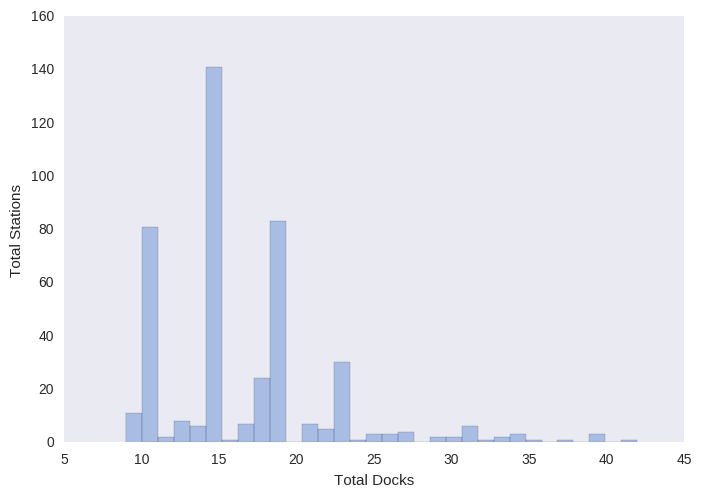

In [18]:
sns.set_style("dark")
sns.color_palette("hls", 8)
diPlot=sns.distplot(stations.nbdocks, kde=False);
diPlot.set(xlabel='Total Docks', ylabel='Total Stations')
diPlot.figure.savefig('static/img/distStations.png')

## Plot Days vs Weekends Distribution

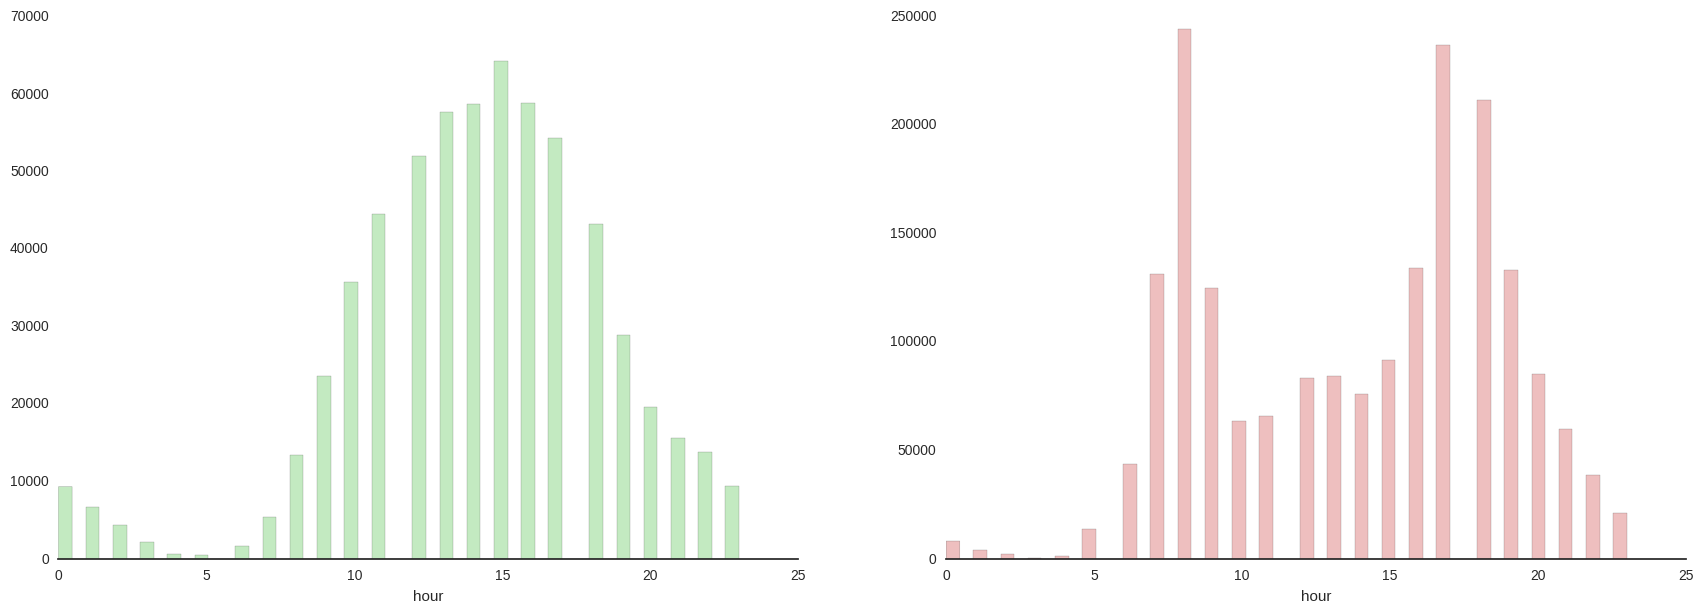

In [84]:
import matplotlib.pyplot as plt 
## Create distribution of Days vs. Weekends rides on hours
weekEndRides=tripData[tripData['day']>=5]['hour']
weekDayRides=tripData[tripData['day']<5]['hour']

sns.set(style="white", palette="muted", color_codes=True)

fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.despine(left=True)

sns.distplot(weekEndRides, kde=False, color='g', ax=ax1)
sns.distplot(weekDayRides, kde=False, color='r', ax=ax2)

#distWeekD=sns.distplot(weekEndRides, kde=False, color="g")
#distWeekE=sns.distplot(weekDayRides, kde=False, color="g")

#distWeekD.figure.savefig('static/img/distWeekD.png')
#distWeekE.figure.savefig('static/img/distWeekE.png')
fig.savefig('static/img/distWeeks.png')


## Plot Chord

In [107]:
##Group Data for chord graph (compare )
chordTable=tripData.groupby(by=['Start station', 'End station', 'Subscription Type','day'], as_index=False)
chordTable=chordTable['Total duration (ms)'].agg(['sum','count'], as_index=False).unstack()

In [108]:
#subtotals & save file
chordTable['sumWeekEnd']=chordTable[('sum',6)]+chordTable[('sum',5)]
chordTable['countWeekEnd']=chordTable[('count',6)]+chordTable[('count',5)]
chordTable['sumWeekDay']=chordTable[('sum',4)]+chordTable[('sum',3)]+chordTable[('sum',2)]+chordTable[('sum',1)]+chordTable[('sum',0)]
chordTable['countWeekDay']=chordTable[('count',4)]+chordTable[('count',3)]+chordTable[('count',2)]+chordTable[('count',1)]+chordTable[('count',0)]
chordTable['sumTotal']=chordTable['sumWeekEnd']+chordTable['sumWeekDay']
chordTable['countTotal']=chordTable['countWeekEnd']+chordTable['countWeekDay']

chordTable=chordTable.reset_index()
chordTable.drop([('sum',0), ('sum',1), ('sum',2), ('sum',3), ('sum',4), ('sum',5), ('sum',6), ('count',0), ('count',1), ('count',2), ('count',3), ('count',4), ('count',5), ('count',6)], axis=1, inplace=True)
chordTable.dropna(inplace=True)
chordTable.to_pickle('Data/chordTable.pkl')

In [98]:
#Read and prepare data
chordTable=pd.read_pickle('Data/chordTable.pkl')
chordTable.sort_values(by='countTotal', ascending=False ,inplace=True)
chordTable=chordTable[chordTable['Start station']!=chordTable['End station']]
chordTable.drop(['sumWeekEnd', 'sumWeekDay', 'countWeekDay', 'sumTotal', 'countWeekEnd'], axis=1, inplace=True)
chordTable.reset_index(inplace=True, drop=True)
chordTable.columns = chordTable.columns.get_level_values(0)

#Get unique stations
listU=chordTable['Start station'].unique()
listU=list(np.unique(np.concatenate([listU,chordTable['End station'].unique()])))
#print ["foo", "bar", "baz"].index("bar")
chordTable['source']=chordTable['Start station']
chordTable['target']=chordTable['End station']

for item in listU:
    chordTable.loc[chordTable['source']==item, 'source']=listU.index(item)
    chordTable.loc[chordTable['target']==item, 'target']=listU.index(item)

chordTable = chordTable[chordTable.source!=chordTable.target]    
    
chordTable[chordTable['Subscription Type']=='Casual'].head(10)
chordTable.tail(5)

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


,Start station,End station,Subscription Type,countTotal,source,target
4200,11th & H St NE,Constitution Ave & 2nd St NW/DOL,Registered,48.0,6,154
4201,N Randolph St & Fairfax Dr,N Nelson St & Lee Hwy,Registered,48.0,226,222
4202,Jefferson Memorial,S Arlington Mill Dr & Campbell Ave,Registered,48.0,192,257
4203,Jefferson Memorial,Aurora Hills Community Ctr/18th & Hayes St,Registered,48.0,192,125
4204,Fessenden St & Wisconsin Ave NW,Friendship Blvd & Willard Ave,Registered,42.0,170,173


In [100]:
#Make the Plot
from bokeh.charts import output_file, Chord
from bokeh.io import show, output_notebook
from bokeh.sampledata.les_mis import data

list2=source_data
list2.loc[list2.source==3, 'name_x']='Smithsonian & Jefferson Dr & 12th St SW'
list2[list2.source==3]['name_x']='Smithsonian / Jefferson Dr & 12th St SW'

chordFromDF=Chord(chordTable, source='Start station', target='End station', value='countTotal')

output_notebook()
show(chordFromDF)

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

In [18]:
## Create chord chart of seasons

from bokeh.charts import output_file, Chord
from bokeh.io import show, output_notebook
from bokeh.sampledata.les_mis import data

nodes = data['nodes']
links = data['links']

nodes_df = pd.DataFrame(nodes)
links_df = pd.DataFrame(links)

source_data = links_df.merge(nodes_df, how='left', left_on='source', right_index=True)
source_data = source_data.merge(nodes_df, how='left', left_on='target', right_index=True)
source_data = source_data[source_data["value"] > 5]

chord_from_df = Chord(source_data, source="name_x", target="name_y", value="value")
output_notebook()
#output_file('chord_from_df.html', mode="inline")
show(chord_from_df)

Loading BokehJS ...

In [39]:
print type(source_data)
source_data.head(20)
#source_data.shape

<class 'pandas.core.frame.DataFrame'>


,source,target,value,group_x,name_x,group_y,name_y
1,2,0,8,1,Mlle.Baptistine,1,Myriel
2,3,0,10,1,Mme.Magloire,1,Myriel
3,3,2,6,1,Mme.Magloire,1,Mlle.Baptistine
47,23,11,9,3,Fantine,2,Valjean
49,24,11,7,4,Mme.Thenardier,2,Valjean
50,25,24,13,4,Thenardier,4,Mme.Thenardier
52,25,11,12,4,Thenardier,2,Valjean
54,26,11,31,5,Cosette,2,Valjean
57,27,11,17,4,Javert,2,Valjean
62,28,11,8,0,Fauchelevent,2,Valjean
